In [8]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd

#To datasets -> import tensorflow_datasets as tfds

# For models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, \
                                    Dropout, Embedding, Input, Concatenate #, Conv2DTranspose

from scipy.stats import nakagami
from scipy.stats import truncnorm
from scipy.stats import uniform
# For visualisation
from matplotlib import pyplot as plt

In [9]:
# generating the data set
k = 2
M = 2**k

NUM_CHANNEL_USES = 2

   
block_size = 32    # num of messages for frames we use, out of this, we use 1/4 as pilots and 3/4 as messages
n_blocks_train = 10**4  ################
n_blocks_val = 10**3
n_blocks_train_GAN = 10**4 #10**5 ###############

n_train = block_size * n_blocks_train
n_val   = block_size * n_blocks_val

n_train_GAN = block_size * n_blocks_train_GAN

num_epoches_AE = 5
num_epoches_WCGAN= 1 #100 ##########################

WCGAN_training_batch_size = 64

In [10]:
channel_parameters = {
    "r"        : 4,             # For upsampling -> number of complex samples per symbol
    "roll_off" : 0.35,          # Roll off factor
    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
    "f_s"      : 25e4,          # Add what is in the physical implementation
    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
    #"time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
    "CFO"      : 5e3,           # Observe from the physical implementation
    "CFO_std"  : 5e3/25e4,      # CFO/f_s
    "snr"      : 6,             # noise power will be calculating assuming transmittting power of 1 
    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
}

nakagami_m = 5 # m=1 for reighley
OMEGA = np.sqrt(2)
AWGN_std = np.sqrt(1/10**(channel_parameters['snr']/10))#np.sqrt(OMEGA * 10 ** (-0.1 * gamma_bar) )


In [11]:
class L2Normalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(L2Normalization, self).__init__(**kwargs)
    def call(self, inputs):
        out = tf.nn.l2_normalize(inputs, axis=-1)
        #print("normalize output shape = ",out.shape)
        return out
    def get_config(self):
        return super(L2Normalization, self).get_config()
    

def generate_nakagami_samples(m, omega):
      
    nakagami_amp_vec = nakagami.rvs(m,omega,size =  NUM_CHANNEL_USES)   # Same gain for the real part and the imaginary part
    nakagami_phase_vec = np.random.uniform(low=0.0, high=2*np.pi, size = NUM_CHANNEL_USES)    # phase shift will effect the complex number
    nakagami_for_real = np.reshape(nakagami_amp_vec*np.cos(nakagami_phase_vec),(-1,1))
    nakagami_for_imag = np.reshape(nakagami_amp_vec*np.sin(nakagami_phase_vec),(-1,1))
    fading_vec = np.reshape(np.concatenate((nakagami_for_real,nakagami_for_imag),axis=1),(1,-1))[0]
    return  tf.constant(fading_vec, dtype=tf.float32)
    
class NakagamiNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, distribution_params, **kwargs):
        super(NakagamiNoiseLayer, self).__init__(**kwargs)
        self.distribution_params = distribution_params
    def call(self, inputs, training=False):
        if  1 or training:
            fading = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"]) 
            return inputs * fading
        else:
            return inputs

In [12]:
# Defining the stochastic channel 

# function to create the complex values
def real_to_complex_tensor(inp_tensor):
  inp_tensor = tf.reshape(inp_tensor, [-1, 2])
  real_part = inp_tensor[:, 0]
  imag_part = inp_tensor[:, 1]
  complex_tensor = tf.complex(real_part, imag_part)
  return complex_tensor

def complex_to_real_tensor(inp_tensor):
   real_part , imag_part = tf.math.real(inp_tensor), tf.math.imag(inp_tensor)
   real_part = tf.reshape(real_part,[-1,1])
   imag_part = tf.reshape(imag_part,[-1,1])
   return tf.reshape(tf.concat([real_part,imag_part],1),[-1])

# Upsample
def upsampling(inp,r):
  com_reshape = tf.reshape(inp,[-1,1])
  padding = tf.constant([[0,0],[0,r-1]])
  upsampled = tf.pad(com_reshape,padding,"CONSTANT")
  return tf.reshape(upsampled,[-1])

# Normalized RRC with time shift
def NRRC_filter(num_taps, roll_off):
  time_delay =  np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
  print("time_delay - ",time_delay)
  t = np.linspace(-(num_taps-1)/2,(num_taps-1)/2,num_taps) - time_delay
  eps = np.finfo(float).eps # Small epsilon to avoid divisiomn by zero
  pi = np.pi
  def RRC_filter_coff(t):
    if abs(t) < eps:  # For t==0
      return 1.0 - roll_off + (4*roll_off/pi)
    elif roll_off != 0 and (abs(t-1/(4*roll_off))<eps or abs(t+1/(4*roll_off))<eps):
      return (roll_off/np.sqrt(2))*(1 + 2/pi)*np.sin(pi/(4*roll_off)) + (1- 2/pi)*np.cos(pi/(4*roll_off))
    else:
      nu = np.sin(pi*t*(1-roll_off)) + 4*roll_off*t*np.cos(pi*t*(1+roll_off))
      den = pi*t*(1-(4*roll_off*t)**2)
      return nu/(den + eps)
  filter_coff = np.array([RRC_filter_coff(T) for T in t])
  NRRC_filter_coff = filter_coff / np.sum(np.abs(filter_coff))
  plt.stem(t,NRRC_filter_coff)  # Plot for visualization
  return tf.constant(NRRC_filter_coff,dtype = tf.float32)

# Phase offset
def PhaseOffset_vec(batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
  l = batch_size*r*NUM_CHANNEL_USES+num_taps-1
  CFO_off =truncnorm.rvs(-1.96,1.96)*CFO_std  # boundaries will be selected for 95% confidence  # 0.1*CFO_std
  print("CFO_off =",CFO_off)   
  print("Phase offset = ",phase_off)                                          # CFO_min and CFO_max (boundaries) will be selected for 95% confidence
  exp_vec = []
  for i in range(l):
    exp_vec.append(tf.math.exp(tf.constant([0+(2*np.pi*i*CFO_off+phase_off)*1j],dtype=tf.complex64)))
  return tf.reshape(tf.stack(exp_vec),[-1])
   

class UpsamplingLayer(keras.layers.Layer):
    def __init__(self, r ):
        super().__init__()
        self.r = r
    def call(self,inputs):
       return upsampling(inputs,self.r)
    
class PulseShaping(keras.layers.Layer): 
    def __init__(self,num_taps,roll_off):
      super().__init__()
      self.nrrc_filter = NRRC_filter(num_taps,roll_off)
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[num_taps,1,1])
      self.num_taps = num_taps
    def call(self, inputs):
      padding_size = self.num_taps // 2
      paddings = tf.constant([[padding_size, padding_size]])
      real_part = tf.pad(tf.math.real(inputs), paddings, "CONSTANT")
      imag_part = tf.pad(tf.math.imag(inputs), paddings, "CONSTANT")
      real_part = tf.reshape(real_part,[1,-1,1])
      imag_part = tf.reshape(imag_part,[1,-1,1])
      real_conv = tf.nn.conv1d(real_part,self.nrrc_filter,stride=1,padding="SAME")
      imag_conv = tf.nn.conv1d(imag_part,self.nrrc_filter,stride=1,padding="SAME")
      real_conv = tf.reshape(real_conv,[-1])
      imag_conv = tf.reshape(imag_conv,[-1])
      return tf.complex(real_conv,imag_conv)

class PhaseOffset(keras.layers.Layer):
    def __init__(self,batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
      super().__init__()
      self.batch_size = batch_size
      self.num_channel_uses = NUM_CHANNEL_USES
      self.num_taps = num_taps
      self.r = r
      self.CFO_std = CFO_std
      self.phase_off = phase_off
    def call(self,inputs):
       return inputs * PhaseOffset_vec(self.batch_size, self.num_channel_uses,self.num_taps,self.r,self.CFO_std, self.phase_off)

class StochasticChannelLayer(keras.layers.Layer):
    """This channel will output 1D tensor.
        channel_parameters ---> custom class for parameters store
                                channel_parameters = {
                                    "r"        : 4,             # For upsampling -> number of complex samples per symbol
                                    "roll_off" : 0.35,          # Roll off factor
                                    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
                                    "f_s"      : 25e4,          # Add what is in the physical implementation
                                    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
                                    #"time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
                                    "CFO"      : 5e3,           # Observe from the physical implementation
                                    "CFO_std"  : 5e3/25e4,      # CFO/f_s
                                    "snr"      : 6,             # noise power will be calculating assuming transmittting power of 1 
                                    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
                                }
        r ----------> upsampling constant (number of complex samples per symbol)
        time_delay -> uniformly distributed time delay between (-1,1), discrete domain, 
                      time dilay is giving relative to the sampling period
        CFO_std ----> CFO_frequency / sampling_frequency is taken as the standared deviation
        snr --------> snr for AWGN channel
        output_shape -> None - output_shape is 1D tensor for sequence decoder, or give an output shape prefer """
    def __init__(self,name,NUM_CHANNEL_USES,batch_size,channel_parameters,**kwargs):
        super(StochasticChannelLayer,self).__init__(name=name,**kwargs)
        self.UpSamplingLayer_inst = UpsamplingLayer(channel_parameters['r'])
        self.PulseShaping_inst = PulseShaping(channel_parameters['num_taps'],channel_parameters['roll_off'])
        self.PhaseOffset_inst = PhaseOffset(batch_size,NUM_CHANNEL_USES,channel_parameters['num_taps'],channel_parameters['r'],channel_parameters['CFO_std'],channel_parameters['phase_off'])
        self.AWGNlayer = keras.layers.GaussianNoise(stddev = np.sqrt(1/10**(channel_parameters['snr']/10)))
    def call(self, inputs):
      inputs = tf.reshape(inputs,[-1])
      inputs = real_to_complex_tensor(inputs)
      x = self.UpSamplingLayer_inst(inputs)
      x = self.PulseShaping_inst(x)
      x = self.PhaseOffset_inst(x)
      x = complex_to_real_tensor(x)
      x = self.AWGNlayer(x)
      #print("StochasticChannelLayer output shape = ",x.shape)
      return x

In [13]:
# Decoder mask layer

class PulseShaping_Dec(keras.layers.Layer): 
    def __init__(self,num_taps,r,roll_off):
      super().__init__()
      self.nrrc_filter = NRRC_filter(num_taps,roll_off)
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[num_taps,1,1])
      self.num_taps = num_taps
      self.r =r
    def call(self, inputs):
      inputs = tf.reshape(inputs,[1,-1,1])
      inp_conv = tf.nn.conv1d(inputs,self.nrrc_filter,stride=self.r,padding="VALID")
      inp_conv = tf.reshape(inp_conv,[-1])
      return inp_conv

class DecoderMaskLayer(keras.layers.Layer):  
    def __init__(self,name,channel_parameters,NUM_CHANNEL_USES):
        super(DecoderMaskLayer,self).__init__(name=name)
        # self.Convo = PulseShaping_Dec(channel_parameters['num_taps'],channel_parameters['r'],channel_parameters['roll_off'])
        self.Convo = tf.keras.layers.Conv1D(1,channel_parameters['num_taps'],strides=channel_parameters['r'], padding = 'valid',activation = 'relu',use_bias=True)
        self.channel_uses = NUM_CHANNEL_USES
    def call(self,inputs):
        inp = tf.reshape(inputs,[-1,2])
        real_part, imag_part = inp[:,0],inp[:,1]
        vec_shape = real_part.shape[0]
        #print("real shape",real_part.shape)
        real_part, imag_part = tf.reshape(real_part,[1,vec_shape,1]), tf.reshape(imag_part,[1,vec_shape,1])
        real_part = tf.reshape(self.Convo(real_part),[-1,1])
        imag_part = tf.reshape(self.Convo(imag_part),[-1,1])
        #print("real shape after conv ",real_part.shape)
        outputs = tf.concat([real_part,imag_part],1)
        return tf.reshape(outputs,[-1,2*self.channel_uses])

In [14]:
# To get the Encoder, channel and the decoder model for given parameteres

def AE_out(k,NUM_CHANNEL_USES,num_epoches,channel_parameters):

    # generating the data set
    x_train = np.array(np.random.rand(n_train,k)<0.5).astype(np.float32)
    y_train = x_train
    x_val = np.array(np.random.rand(n_val,k)<0.5).astype(np.float32)
    y_val = x_val

    act_func = 'tanh' # 'relu'

    print(f"-------  start ----------")

    def create_AE():
        AE = Sequential([

                        Dense(2**k, activation=act_func,input_shape=(k,)),
                        Dense(2**k, activation=act_func),
                        Dense(2*NUM_CHANNEL_USES, activation='linear',name="Encode_last_dense"),
                        L2Normalization(name="normalization_layer"),
                        #L2Normalization_Range(NUM_CHANNEL_USES),####
                        
                        StochasticChannelLayer("st_channel",NUM_CHANNEL_USES,block_size,channel_parameters), 
                        
                        #NakagamiNoiseLayer({"omega":OMEGA,"m":nakagami_m}),
                        #keras.layers.GaussianNoise(stddev = AWGN_std),

                        DecoderMaskLayer("decoder_mask",channel_parameters,NUM_CHANNEL_USES),
                        Dense(2**k, activation=act_func,name="decoder_start"),
                        Dense(2**k, activation=act_func,name="decoder_middle"),
                        Dense(k, activation='sigmoid')

                        ])
        return AE

    AE = create_AE()
    AE.summary()
    history = []

    callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=3)
    AE.compile(optimizer=Adam(learning_rate=1e-2),loss="binary_crossentropy")
    history.append(AE.fit(x_train,y_train,batch_size=block_size,epochs=num_epoches,verbose=2,validation_data=(x_val,y_val),callbacks=[callback]))
    AE.compile(optimizer=Adam(learning_rate=1e-3),loss="binary_crossentropy")
    history.append(AE.fit(x_train,y_train,batch_size=block_size,epochs=num_epoches,verbose=2,validation_data=(x_val,y_val),callbacks=[callback]))

    preds = AE.predict(x_val,batch_size=block_size)>0.5
    #         accuracy = np.mean( preds == y_val  )
    def calc_block_accuracy(preds,y_val):
        n_bits_per_block = preds.shape[1]
        n_correct_bits = np.sum(preds == y_val,axis=1)
        block_accuracy = np.mean(n_correct_bits == n_bits_per_block)
        return block_accuracy
    accuracy =  calc_block_accuracy(preds,y_val)
    print(f"validation accuracy = {accuracy}")

    encoder = Model(inputs=AE.input,outputs=AE.get_layer('normalization_layer').output)
    channel = Model(inputs = AE.get_layer("st_channel").input,outputs=AE.get_layer("st_channel").output)
    decoder = Model(inputs=AE.get_layer("decoder_mask").input,outputs=AE.output)

    return  encoder , channel, decoder

### Conditional wasserstein GAN
https://www.kaggle.com/code/ritvik1909/wasserstein-gan-with-gradient-penalty

https://github.com/Mohammad-Rahmdel/WassersteinGAN-GradientPenalty-Tensorflow/blob/master/WGAN-GP_MNIST.ipynb

https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/

In [15]:
# Conditional Wasserstein GAN

"""
Conditional info ----> Pilot encoder symbols  + Channel outputs for pilot symbols +  + Encoder outputs (all the channel uses)
                       If the num_channel_uses = 2, there will be two vectors of length 4,  concaternated. 
                       block_size = 32
                       num_taps = 31
                       upsampling factor = 4  
                       First vector is the real and imaginary of the encoder outputs (4)
                       Pilot encoder symbols  -> 2* NUM_CHANNEL_USES * block_size = 128
                       Channel outputs for pilot symbols -> 2* NUM_CHANNEL_USES * block_size*channel_parameters['r']+2*(channel_parameters['num_taps']-1) = 572
Genarator inputs ----> Noise vector of encoder outpus size (2* NUM_CHANNEL_USES * block_size = 128) + conditional infomation
Discriminator inputs -> Channel output of real samples + conditional information
 """

def build_generator():
    inp_length = 2* NUM_CHANNEL_USES * block_size
    noise = Input(shape= (inp_length,))
    # input_pilot_conditional = Input(shape=(inp_length,))
    # channel_output_pilot_conditionals = Input(shape=(inp_length*channel_parameters['r']+2*(channel_parameters['num_taps']-1),))
    # enc_out_conditional = Input(shape = (inp_length,))#(shape=(2,)) # real and imag parts of any symbol
    conditional_arr = Input(shape=(2*inp_length+inp_length*channel_parameters['r']+2*(channel_parameters['num_taps']-1)),)
    concat = Concatenate()([noise,conditional_arr])

    l = Dense(128)(concat)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(128)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(128)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    output = Dense(inp_length*channel_parameters['r']+2*(channel_parameters['num_taps']-1),activation='linear')(l)#(2,activation = 'linear')(l) # real and imag parts of any symbol

    model = Model([noise,conditional_arr],output)
    return model

generator = build_generator()

generator.summary()
# tf.keras.utils.plot_model(generator, show_shapes=True)


def build_discriminator():
    inp_length = 2* NUM_CHANNEL_USES * block_size
    dicr_inp = Input(shape =(inp_length*channel_parameters['r']+2*(channel_parameters['num_taps']-1),))
    # input_pilot_conditional = Input(shape=(inp_length,))#(2  **k  *NUM_CHANNEL_USES  *2,))
    # channel_output_pilot_conditionals = Input(shape=(inp_length*channel_parameters['r']+2*(channel_parameters['num_taps']-1),))
    # enc_out_conditional = Input(shape = (inp_length,))#(shape=(2,)) # real and imag parts of any symbol
    conditional_arr = Input(shape=(2*inp_length+inp_length*channel_parameters['r']+2*(channel_parameters['num_taps']-1)),)
    concat = Concatenate()([dicr_inp,conditional_arr])

    l = Dense(32)(concat)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(32)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(32)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    output = Dense(1,activation = 'linear')(l)

    model = Model([dicr_inp,conditional_arr],output)
    return model

discriminator = build_discriminator()

discriminator.summary()
# tf.keras.utils.plot_model(discriminator, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 828)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 956)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          122496      ['concatenate[0][0]']        

In [16]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

def gradient_penalty(batch_size, real, fake, conditional_arr,discriminator):
    epsilon = tf.random.normal([batch_size, 1], 0.0, 1.0)#tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = epsilon*real + (1-epsilon)*fake #real + epsilon * diff
    interpolated=[interpolated,conditional_arr]##############
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm =tf.sqrt(tf.reduce_sum(tf.square(grads[0]), axis=[1])+tf.reduce_sum(tf.square(grads[1]), axis=[1])) #tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [17]:
# CWGAN definition
# https://www.kaggle.com/code/ritvik1909/wasserstein-gan-with-gradient-penalty

# optimizers
opt_g = Adam(learning_rate=0.001, beta_1=0.5)
opt_d = Adam(learning_rate=0.0001, beta_1=0.5)

# models remain the same
generator_CWGAN = build_generator()
discriminator_CWGAN = build_discriminator()

# custom training step to include Wasserstein loss and gradient penalty
class WGANGP(Model):
    def __init__(self ,latent_dim ,discriminator_extra_steps , generator, discriminator, **kwargs):
        super(WGANGP, self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim        # 2*NUM_CHANNEL_USES prefered
        self.d_steps = discriminator_extra_steps    # prefered 5
        self.lambda_gp = 10.0  # gradient penalty weight

    def compile(self, g_optimizer, d_optimizer,**kwargs): #, g_loss_fn, d_loss_fn, **kwargs):
        super(WGANGP, self).compile(**kwargs)
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        #self.g_loss_fn = g_loss_fn
        #self.d_loss_fn = d_loss_fn

    def train_step(self,dataset):# real_channel_outputs,input_pilot_conditionals,channel_output_pilot_conditionals,enc_out_conditional ):

        real_channel_outputs,conditional_arr = dataset

        ########################################
        # if isinstance(real_channel_outputs, tuple):
        #     real_channel_outputs = real_channel_outputs[0]

        batch_size = tf.shape(real_channel_outputs)[0]
        #print("GAN batch ",tf.shape(real_channel_outputs)[0])

        # train discriminator (critic)
        for _ in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            inputs = [random_latent_vectors,conditional_arr]
            real_channel_dic_in = [real_channel_outputs,conditional_arr]
            with tf.GradientTape() as tape:
                fake_channel_outputs = self.generator(inputs, training=True)
                fake_channel_disc_in = [fake_channel_outputs,conditional_arr]
                fake_logits = self.discriminator(fake_channel_disc_in, training=True)
                real_logits = self.discriminator(real_channel_dic_in, training=True)
                # d_cost = self.d_loss_fn(tf.ones_like(real_logits), real_logits) + \
                #         self.d_loss_fn(-tf.ones_like(fake_logits), fake_logits)
                d_cost = -tf.reduce_mean(real_logits) + tf.reduce_mean(fake_logits)
                gp = gradient_penalty(batch_size, real_channel_outputs, fake_channel_outputs, conditional_arr,self.discriminator)
                d_loss = d_cost + self.lambda_gp * gp

            d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        inputs = [random_latent_vectors,conditional_arr]
        with tf.GradientTape() as tape:
            generated_channel_outputs = self.generator(inputs, training=True)
            generated_disc_in = [generated_channel_outputs,conditional_arr]
            generated_channel_output_logits = self.discriminator(generated_disc_in, training=True)
            g_loss = -tf.reduce_mean(generated_channel_output_logits) #self.g_loss_fn(-tf.ones_like(generated_channel_output_logits), generated_channel_output_logits)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {'d_loss': d_loss, 'g_loss': g_loss}

# # compile the model
# gan = WGANGP(2*NUM_CHANNEL_USES,5,generator_CWGAN, discriminator_CWGAN)
# gan.summary()
# gan.compile(
#     g_optimizer=opt_g,
#     d_optimizer=opt_d,
#     #g_loss_fn=wasserstein_loss,
#     #d_loss_fn=wasserstein_loss,
# )

# # training
# history = gan.fit(dataset, batch_size=block_size, epochs=num_epoches_WCGAN)

### Evaluating with synthetic data

In [31]:
full_message_space = []
for i in range(2**k):
    binary_str = bin(i)[2:]
    binary_str = binary_str.zfill(k)
    binary_int_list = [int(bit) for bit in binary_str]
    full_message_space.append(binary_int_list)
assert block_size%2**k==0 and block_size>=2**k, "cannot insert the pilots"

pilot_portion_of_block = np.tile(np.array(full_message_space),(8//(2**k),1))

In [51]:
# if True and "just testing the below function ":
#     n_train_GAN_payload = n_train_GAN//4  *3 # onlt 75% payload --> 25% pilots
#     x_train_GAN_payload = np.array(np.random.rand(n_train_GAN_payload,k)<0.5).astype(np.float32)
#     x_train_GAN = np.zeros((n_train_GAN,k))
#     for block_i in range(n_blocks_train_GAN//4):
#         x_train_GAN[32*block_i:32*block_i+8,:] = pilot_portion_of_block
#         x_train_GAN[32*block_i+8:32*(block_i+1),:] = x_train_GAN_payload[24*block_i:24*(block_i+1),:]
#     print(x_train_GAN.dtype)
#     print(np.all(x_train_GAN[0:8,:] == x_train_GAN[32:40,:])) 

float64
True


In [45]:
# Create GAN dataset
"""
ex:- 
    block_size = 32
    NUM_CHANNEL_USES = 2
    r = 4 (upsampling factor in the channel)
    num_taps = 31 (taps for RRC filter used in the channel)

    For a block,
    expected channel input size = block_size,2*NUM_CHANNEL_USES = (32,4)
    expected channel output size = block_size*2*NUM_CHANNEL_USES*r + 2*(num_taps-1) 
                                 = 32*2*2*4 + 2*(31-1) = 572
    conditionala_array ---> channel_input_pilot_samples (32*4 =128) + channel_output_pilot_samples (32*4*4+2*(31-1) = 572) + encoder_output (channel input) (32*4=128)
    """

def creat_GAN_dataset(k,NUM_CHANNEL_USES,encoder,channel,channel_parameters):
    n_train_GAN_payload = n_train_GAN//4  *3 # onlt 75% payload --> 25% pilots
    x_train_GAN_payload = np.array(np.random.rand(n_train_GAN_payload,k)<0.5).astype(np.float32)
    x_train_GAN = np.zeros((n_train_GAN,k))
    for block_i in range(n_blocks_train_GAN//4):
        x_train_GAN[32*block_i:32*block_i+8,:] = pilot_portion_of_block
        x_train_GAN[32*block_i+8:32*(block_i+1),:] = x_train_GAN_payload[24*block_i:24*(block_i+1),:]
    
    enc_out = encoder.predict(x_train_GAN,batch_size=block_size)
    print(enc_out.shape)
    channel_out = channel.predict(enc_out, batch_size = block_size)
    print(channel_out.shape)
    chan_out_block_size=(block_size*channel_parameters['r']*2*NUM_CHANNEL_USES+2*(channel_parameters['num_taps']-1))
    print("chan_out_block_size = ",chan_out_block_size)

    enc_out = np.reshape(enc_out,(-1,4,block_size*2*NUM_CHANNEL_USES))
    channel_out = np.reshape(channel_out,(-1,4,chan_out_block_size))
    enc_out_p_arr = np.reshape(np.repeat(enc_out[:,0,:],3,0),(-1,block_size*2*NUM_CHANNEL_USES))    # No need to reshape
    enc_out_cond_arr= np.reshape(enc_out[:,1:4,:],(-1,block_size*2*NUM_CHANNEL_USES))
    chan_out_p_arr = np.reshape(np.repeat(channel_out[:,0,:],3,0),(-1,chan_out_block_size)) # No need to reshape
    chan_out_real_arr = np.reshape(channel_out[:,1:4,:],(-1,chan_out_block_size))
    
    conditional_arr = np.concatenate((enc_out_p_arr, chan_out_p_arr,enc_out_cond_arr),axis = 1)
    return chan_out_real_arr, conditional_arr

# chan_out_real_arr, conditional_arr = creat_GAN_dataset(k,NUM_CHANNEL_USES,encoder,channel,channel_parameters)
# print("chan_out_real_arr shape",chan_out_real_arr.shape)
# print("conditional_arr shape",conditional_arr.shape)

Defining the GAN model and evaluation

In [46]:
def Train_and_Get_CWGAN(channel_parameters_list,k,NUM_CHANNEL_USES):

    # optimizers
    opt_g = Adam(learning_rate=0.001, beta_1=0.5)
    opt_d = Adam(learning_rate=0.0001, beta_1=0.5)
    # models remain the same
    generator_CWGAN = build_generator()
    discriminator_CWGAN = build_discriminator()
    # compile the model
    gan = WGANGP(2*NUM_CHANNEL_USES*block_size,5,generator_CWGAN, discriminator_CWGAN)
    gan.compile(
        g_optimizer=opt_g,
        d_optimizer=opt_d,
        #g_loss_fn=wasserstein_loss,
        #d_loss_fn=wasserstein_loss,
    )

    # the part below will train the model for different channel instances

    history = []
    i=0
    for channel_parameters in channel_parameters_list:

        # GAN dataset
        if i==0:
            encoder , channel, decoder = AE_out(k,NUM_CHANNEL_USES,num_epoches_AE,channel_parameters)   # need to fix encoder after the first channel, if we train for sevaral channels
            encoder_1=encoder
            decoder_1=decoder
            channel_1=channel
        else:
            inp_length = 2* NUM_CHANNEL_USES * block_size
            chan_model = Sequential([
                Input(shape= (inp_length,)),
                StochasticChannelLayer("st_channel",NUM_CHANNEL_USES,block_size,channel_parameters)])
            channel = Model(inputs = chan_model.get_layer("st_channel").input,outputs=chan_model.get_layer("st_channel").output) 

        chan_out_real_arr, conditional_arr = creat_GAN_dataset(k,NUM_CHANNEL_USES,encoder_1,channel,channel_parameters)
        i+=1
        # training
        history.append(gan.fit(chan_out_real_arr, conditional_arr, batch_size=WCGAN_training_batch_size, epochs=num_epoches_WCGAN))

    return gan , encoder_1, channel_1, decoder_1, history

-------  start ----------
time_delay -  (0.8792610811127999,)
CFO_off = -0.016086844081690227
Phase offset =  5.961698624639039
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 4)                 12        
                                                                 
 dense_25 (Dense)            (None, 4)                 20        
                                                                 
 Encode_last_dense (Dense)   (None, 4)                 20        
                                                                 
 normalization_layer (L2Norm  (None, 4)                0         
 alization)                                                      
                                                                 
 st_channel (StochasticChann  (572,)                   0         
 elLayer)                                                   

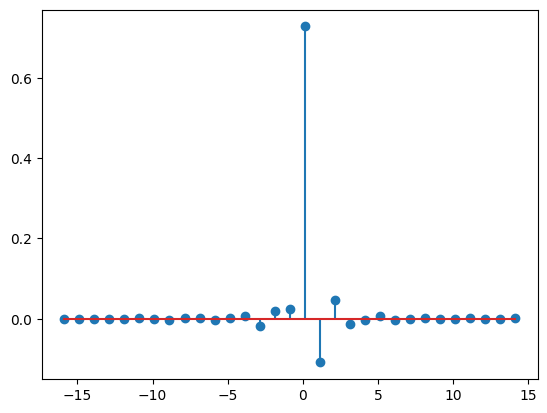

In [47]:
channel_parameters = {
                        "r"        : 4,             # For upsampling -> number of complex samples per symbol
                        "roll_off" : 0.35,          # Roll off factor
                        "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
                        "f_s"      : 25e4,          # Add what is in the physical implementation
                        "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
                        #"time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
                        "CFO"      : 5e3,           # Observe from the physical implementation
                        "CFO_std"  : 5e3/25e4,      # CFO/f_s
                        "snr"      : 6,             # noise power will be calculating assuming transmittting power of 1 
                        "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
                                }   

# If the moedl needs to be trained for different channel instances, add thoes channel parameteres inside the channel_parameteres_list
channel_parameters_list = [channel_parameters]
cwgan , encoder, channel,decoder, history = Train_and_Get_CWGAN(channel_parameters_list,k,NUM_CHANNEL_USES)


dict_keys(['d_loss', 'g_loss'])


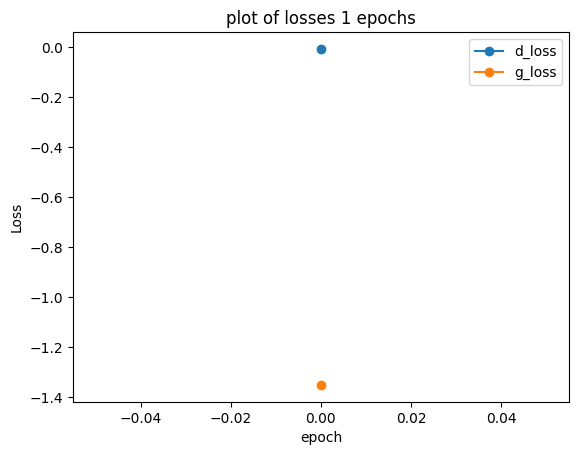

In [50]:
# Ploting
print(history[0].history.keys())
plt.plot(history[0].history['d_loss'],marker="o") # history[0] for the first channel instance
plt.plot(history[0].history['g_loss'],marker="o")
plt.title('plot of losses '+str(num_epoches_WCGAN)+' epochs')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'])
plt.show()

Testing the GAN

10000/10000 [==============================] - 10s 957us/step
(320000, 4)
10000/10000 [==============================] - 11s 1ms/step
(5720000,)
chan_out_block_size =  572
118/118 [==============================] - 0s 3ms/step
chan_out_real_arr shape (7500, 572)
conditional_arr shape (7500, 828)
gan_out shape (7500, 572)
(4290000,)
(4290000,)


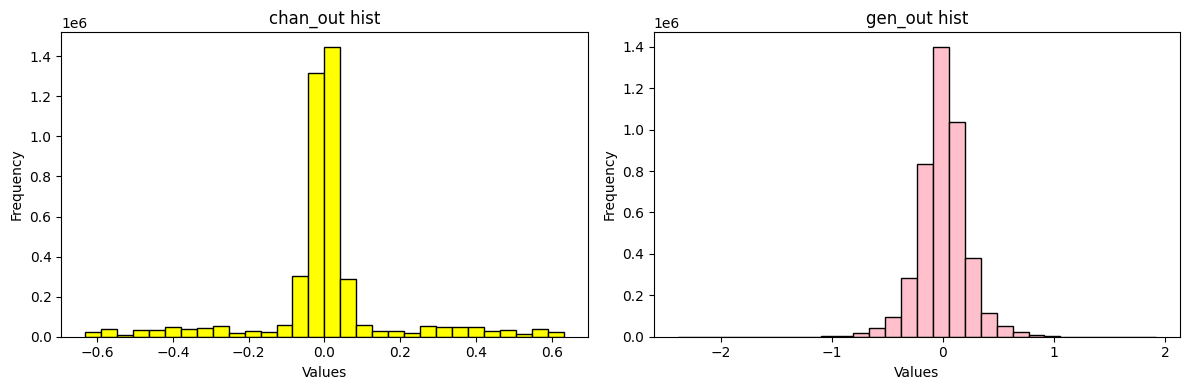

In [34]:
chan_out_real_arr, conditional_arr = creat_GAN_dataset(k,NUM_CHANNEL_USES,encoder,channel,channel_parameters)

random_latent_vectors = tf.random.normal(shape=(conditional_arr.shape[0], 2*NUM_CHANNEL_USES*block_size))
gan_inputs = [random_latent_vectors, conditional_arr]
gan_out = cwgan.generator.predict(gan_inputs,batch_size=64)

print("chan_out_real_arr shape",chan_out_real_arr.shape)
print("conditional_arr shape",conditional_arr.shape)
print("gan_out shape",gan_out.shape)

chan_out_values = np.reshape(chan_out_real_arr,(-1))
gan_out_values = np.reshape(gan_out,(-1))
print(chan_out_values.shape)
print(gan_out_values.shape)

# Creating multiple histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(chan_out_values, bins=30, color='Yellow', edgecolor='black')
axes[0].set_title('chan_out hist')
 
axes[1].hist(gan_out_values, bins=30, color='Pink', edgecolor='black')
axes[1].set_title('gen_out hist')
for ax in axes:
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
 
plt.tight_layout()
plt.show()